In [1]:
import ocel
import networkx as nx
import ocel_features.util.experimental.convert_neo4j as n4j
import ocel_features.analysis.plot_graphs as pg
from datetime import timedelta
from pprint import pprint

In [2]:
log = ocel.import_log('../logs/running-example.jsonocel')

In [3]:
# Create invertible graph from log
log_graph = n4j.convert_log_to_labeled_graph(log)
edf = n4j.event_directly_follows(log)

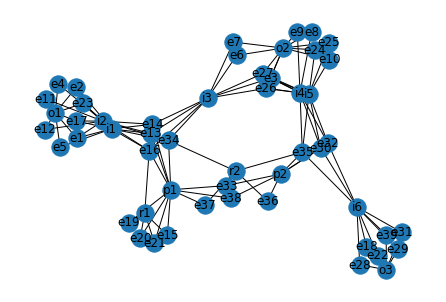

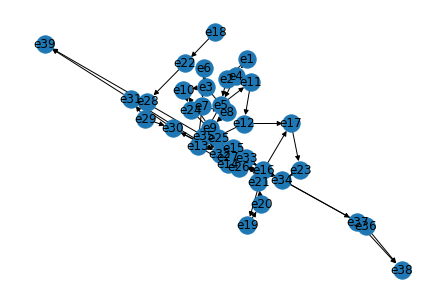

In [4]:
pg.basic_graphviz(log_graph)
pg.basic_graphviz(edf)

In [5]:
week_logs = n4j.split_by_days_of_week(log, set(range(5)))

In [3]:
graphs = n4j.get_weekly_graphs(log, set(range(5)))

[0, 1, 2, 3, 4]
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [6]:
for k, v in graphs.items():
    print(f'graph from week [{k}, {k + timedelta(days=7)}):')
    pg.show_graph_plt(v)
    print(v)
    break

graph from week [2019-05-20, 2019-05-27):
"neato" with args ['-Tdot', '/tmp/tmpqrbfgao7'] returned code: 1

stdout, stderr:
 b''
b"Error: /tmp/tmpqrbfgao7: syntax error in line 2 near ':'\n"



AssertionError: "neato" with args ['-Tdot', '/tmp/tmpqrbfgao7'] returned code: 1

<Figure size 432x288 with 0 Axes>